In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 256

def loadImages(data_dir):
    data=[]
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
#             print(img_path)
            img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(img_size,img_size))
    
            data.append([img, class_num])
        
    return np.array(data)


In [10]:
os.listdir('./chest_xray/test/')

['NORMAL', 'PNEUMONIA']

In [4]:
test = loadImages('./chest_xray/test')
train = loadImages('./chest_xray/train')
val = loadImages('./chest_xray/val')

C:\Users\Aditya\AppData\Local\Temp\ipykernel_9396\695952986.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


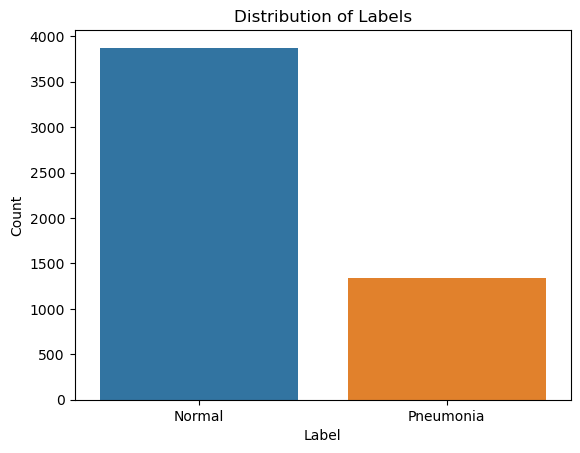

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the count of each category
label_counts = pd.Series([i[1] for i in train]).value_counts()

# Plot the count of each category
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(ticks=range(len(label_counts)), labels=["Normal", "Pneumonia"])  # Optional: Specify x-axis labels
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

Text(0.5, 1.0, 'NORMAL')

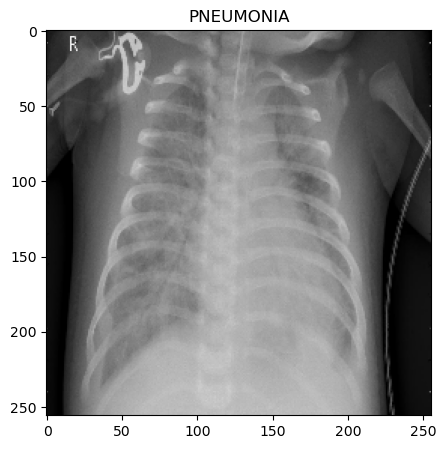

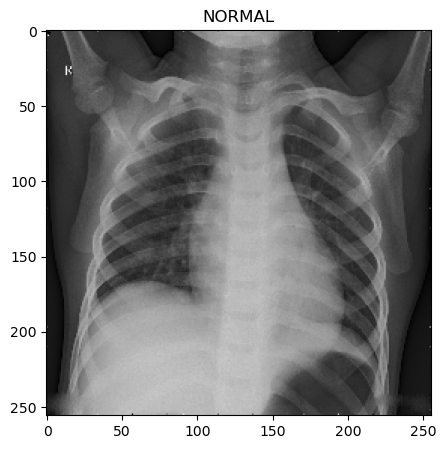

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# Normalizing the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [19]:
# resize data 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(  
        rotation_range = 30,  
        zoom_range = 0.2,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)  


datagen.fit(x_train)

In [18]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (256,256,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)    

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 15 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

In [46]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 8s 391ms/step - loss: 0.2588 - accuracy: 0.9022
Loss of the model is -  0.2587859630584717
20/20 [==============================] - 8s 386ms/step - loss: 0.2588 - accuracy: 0.9022
Accuracy of the model is -  90.22436141967773 %


In [26]:
modelP = tf.keras.models.load_model('pneumonia_model.h5')